## Funciondes de ploteo y análisis
https://projects.susielu.com/viz-palette?colors=[%22#cccccc%22,%22#38d971%22,%22#fa8775%22,%22#ffd700%22,%22#57d7de%22,%22#cd34b5%22,%22#0000ff%22,%22#e73a34%22,%22#9d02d7%22,%22#76f53c%22,%22#ea5f94%22,%22#ffb14e%22]&backgroundColor=%22#1d163d%22&fontColor=%22black%22


In [196]:
import warnings
warnings.filterwarnings("ignore")

In [197]:
## Silhouette  test
#Determina el numero optimo de clusters
def test_silueta(df):
    import hdbscan 
    from sklearn.metrics import davies_bouldin_score

    rango_vecinos=[]
    num_clusters = []
    silueta = []
    calinski = []
    bouldin = []

    X = np.array(sample )  
    # Estandarización
    #scaler = StandardScaler().fit(X)
    #X = scaler.transform(X)

    for n in   range(1 , 200) :  
        model = hdbscan.HDBSCAN(min_cluster_size=n+1   ).fit(X) 
        n_clusters_ = len(set(model.labels_ )) - (1 if -1 in model.labels_  else 0)

        if n_clusters_!= 0 :
            rango_vecinos.append(n+1)
            num_clusters.append( n_clusters_ )
            # buscamos valores cerca de 1
            silueta.append( metrics.silhouette_score( X , model.labels_ ))  
            
            # buscamos el valor mas grande
            calinski.append( metrics.calinski_harabaz_score(X, model.labels_))
            
            # buscamos el valor minimo
            bouldin.append(davies_bouldin_score(X, model.labels_))
             
        else:
            break;

    bench_df = pd.DataFrame({
        "num_vecinos":rango_vecinos,
        "num_clusters": num_clusters ,
        "silueta":silueta , 
        'calinski':calinski , 
        'bouldin':bouldin
    } )  
    bench_df.to_csv('bench.csv', sep=';' , index=False , decimal = ',')
    return  bench_df

In [198]:
# scatter luedo de HDBSCAN
def scatter(x_pos ,y_pos): 
    ## solo va a funcionar se existe se corrio hdbscan
    trace = go.Scatter(
        x = X[:, x_pos],   
        y = X[:, y_pos],   
        mode = 'markers', 
        marker=dict(color= labels_   ,
                     colorscale=[
                        [0.0               ,'rgb(204,204,204)',],
                        [0.0               ,'rgb(204,204,204)', ],
                        [0.0111111111111111,'rgb(56,217,113)', ],
                        [0.1111111111111111,'rgb(250,135,117)', ],
                        [0.2222222222222222,'rgb(255,215,0)', ],
                        [0.2555555555555555,'rgb(87,215,222)',  ],
                        [0.3333333333333333,'rgb(205,52,181)', ],
                        [0.4444444444444444,'rgb(0,0,255)', ],
                        [0.5555555555555556,'rgb(231,58,52)', ],
                        [0.6666666666666666,'rgb(157,2,215)', ],
                        [0.7777777777777778,'rgb(118,245,60)',  ],
                        [0.8888888888888888,'rgb(234,95,148)',  ],
                        [1.0               ,'rgb(255,177,78)'  ]] 
                   
                   )
    ) 
    layout = go.Layout(
        title='Segmentación de clientes HDBSCAN '+str(registros)+' Registros'+' '+str(n_clusters_)+' Clusters' ,
        plot_bgcolor = '#FFFFFF',
        paper_bgcolor = '#FFFFFF', 
        xaxis=dict(
                title=sample.columns[x_pos] 
            ),
            yaxis=dict(
                title=sample.columns[y_pos]
            ) 
    )
    data = [trace] 
    fig = go.Figure(data = data, layout = layout)
    # Plot and embed in ipython notebook!
    return fig 
#py.iplot(fig ,   filename='scatter_hdbscan')


In [199]:
def ploty_scatter(x , y ):
    # Create a trace
    trace = go.Scatter(
        x = x,   
        y = y,   
        mode = 'markers', 
        marker=dict(colorscale='Jet') 
    ) 
    layout = go.Layout( 
        plot_bgcolor = '#FFFFFF',
        paper_bgcolor = '#FFFFFF' 
    )
    data = [trace] 
    fig = go.Figure(data = data, layout = layout)
    # Plot and embed in ipython notebook!
    #py.iplot(fig ,   filename='simple_scatter') 
    return fig 

In [200]:
def caja(df):
    trace0 = go.Box(
        y=df
    ) 
    data = [trace0 ] 
    fig = go.Figure(data = data )  
    return fig
     
#fig = caja(sample['FACTURACION_PROMEDIO'])
#py.iplot(fig ,   filename='caja') 

In [201]:
def plot_test( df ): 
     
    # 'num_vecinos', 'num_clusters', 'silueta', 'calinski', 'bouldin'
    x = df.index
    
    trace1 = go.Scatter(
        x=x,
        y=df.silueta,
        name='Silueta',
        mode='lines+markers'
    )
    trace2 = go.Scatter(
        x=x,
        y=df.calinski,
        name='Calinski',
        yaxis='y2',
        mode='lines+markers'
    )
    trace3 = go.Scatter(
        x=x,
        y=df.bouldin,
        name='Bouldin',
        yaxis='y3',
        mode='lines+markers'
    )
    trace4 = go.Scatter(
        x=x,
        y=df.num_clusters,
        name='Clusters',
        yaxis='y4',
        mode='lines+markers'
    )
    trace5 = go.Scatter(
        x=x,
        y=df.num_vecinos,
        name='mpts',
        yaxis='y5',
        mode='lines+markers'
    )
    
    data = [trace1, trace2, trace3 ,  trace4  , trace5]
    
    layout = go.Layout(
        title='Testing',
        width=900, 
        yaxis=dict(
            title='Silueta',
            titlefont=dict(
                color='#1f77b4'
            ),
            tickfont=dict(
                color='#1f77b4'
            )
        ),
        yaxis2=dict(
            title='Calinski',
            titlefont=dict(
                color='#ff7f0e'
            ),
            tickfont=dict(
                color='#ff7f0e'
            ),
            anchor='free',
            overlaying='y',
            side='left',
            position=0.15
        ),
        yaxis3=dict(
            title='Bouldin',
            titlefont=dict(
                color='#d62728'
            ),
            tickfont=dict(
                color='#d62728'
            ),
            anchor='x',
            overlaying='y',
            side='right'
        ),
        yaxis4=dict(
            title='Clusters',
            titlefont=dict(
                color='#fc3737'
            ),
            tickfont=dict(
                color='#fc3737'
            ),
            anchor='free',
            overlaying='y',
            side='right',
            position=0.85
        ),
        yaxis5=dict(
            title='Mpts',
            titlefont=dict(
                color='#42f4d4'
            ),
            tickfont=dict(
                color='#42f4d4'
            ),
            anchor='free',
            overlaying='y',
            side='right',
            position=0.65
        )
    )
    fig = go.Figure(data=data, layout=layout)
    #plot_url = py.plot(fig, filename='multiple-axes-multiple')
    return fig  

In [202]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.plotly as py
import plotly.graph_objs as go 
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 

#plotly.tools.set_credentials_file(username='slotbite', api_key='GYgRt3eXz6IdiIy3k7sO')
py.plotly.tools.set_credentials_file(username='cachulooo', api_key='srvpWbqoQ27WdGO3pArx')

 
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

In [265]:
# Cargando datos
data = pd.read_csv("segmentacion_clientes.csv" , delimiter=";" , decimal="," , encoding='utf-8')

In [266]:
df=data

In [267]:
#sample=df
#sample = df[(sample.QUEJAS==2)] 
#plt.xticks(rotation=90)
#sample.groupby('COMUNA').size().sort_values(ascending=False) 

## Muestreo de distrubuciones

```
sample=df
#sample = df[(sample.QUEJAS==2) ] 
plt.xticks(rotation=90)
plt.plot(sample.groupby('QUEJAS').size().sort_values(ascending=False))
```

## Categorización <br> Encodificación <br> Estandarización

In [268]:
# Eliminacion de outliers (-)
df = df[df.PRODUCT_ID > 0] 
df = df[(df.FACTURACION_PROMEDIO > 0 ) & (df.FACTURACION_PROMEDIO <= 397000 )] 
df = df[(df.SALDO_PROMEDIO > 0 ) & (df.SALDO_PROMEDIO <= 401500 )]  


## Convertimos las variables categoricas
#http://pbpython.com/categorical-encoding.html
pd.options.mode.chained_assignment = None
df["COMUNA"] = df["COMUNA"].astype('category')
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].astype('category')
df["TI"] = df["TI"].astype('category')
df["TI2"] = df["TI2"].astype('category')

# luego la encodificamos 
df["TI"] = df["TI"].cat.codes
df["TI2"] = df["TI2"].cat.codes
df["COMUNA_ENC"] = df["COMUNA"].cat.codes 
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].cat.codes 
df[:3]

,PRODUCT_ID,SUBSCRIPTION_ID,SUBSCRIBER_ID,COMUNA,TI,TI2,TIPO_REPARTO,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC
0,122551,122551,13185036,128 - San Esteban ...,0,0,0,0,0,0,0,18964.8333,33256.6667,1.753504,8
1,122581,122581,122581,128 - San Esteban ...,0,0,0,0,0,0,0,28445.7500,36605.0833,1.286793,8
2,109938,109938,3665521,145 - San Felipe ...,0,1,0,0,0,1,0,135045.4170,327823.5000,2.427488,18


In [269]:
df.columns

Index(['PRODUCT_ID', 'SUBSCRIPTION_ID', 'SUBSCRIBER_ID', 'COMUNA', 'TI', 'TI2',
       'TIPO_REPARTO', 'QUEJAS', 'DAÑOS', 'CORTES', 'RECLAMOS',
       'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO', 'ROTACION_CARTERA',
       'COMUNA_ENC'],
      dtype='object')

## Correlacion de variables 

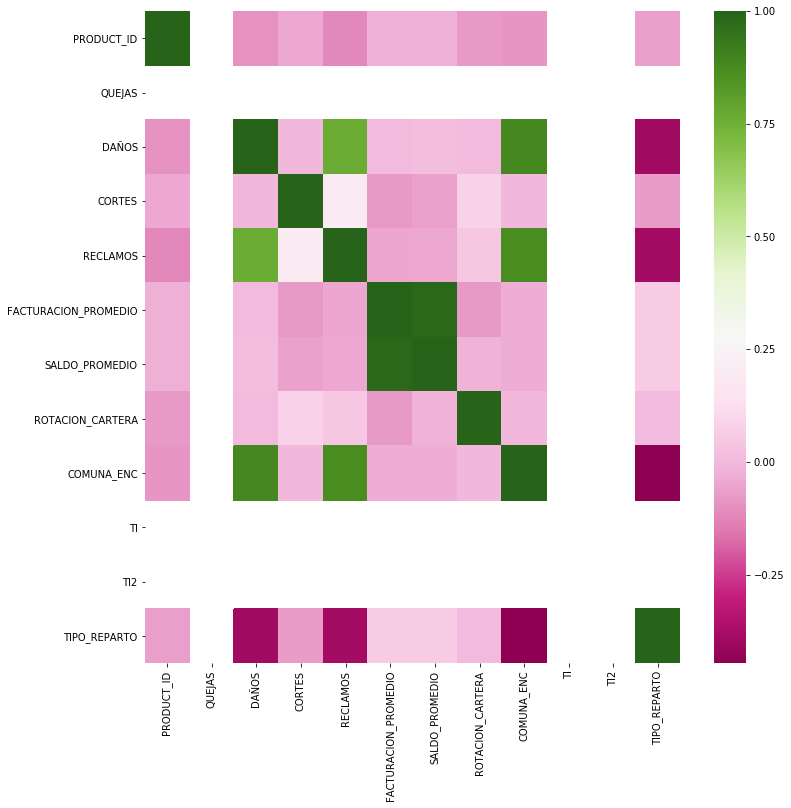

In [270]:
## SELECCION PARA NUMERO DE QUEJAS 9  
features=['PRODUCT_ID' , 'QUEJAS', 'DAÑOS',
            'CORTES', 'RECLAMOS','FACTURACION_PROMEDIO',
            'SALDO_PROMEDIO', 'ROTACION_CARTERA' ,
           'COMUNA_ENC' , 'TI' , 'TI2' ,'TIPO_REPARTO' ]
 
# selecciono el intervalo a trabajar 
sample = df[(df.QUEJAS==9)] 
 
# seleccion de variables a trabajar 
sample = sample[features]


matrix_coor = sample.corr(method='pearson' ) #‘pearson’, ‘kendall’, ‘spearman’ 

#print(matrix_coor)
sns.heatmap(matrix_coor, cmap="PiYG") 

In [271]:
sample.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('PiYG'), axis=1)

,PRODUCT_ID,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC,TI,TI2,TIPO_REPARTO
PRODUCT_ID,1.0,nan,-0.092,-0.042,-0.12,-0.027,-0.025,-0.075,-0.09,nan,nan,-0.064
QUEJAS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
DAÑOS,-0.092,nan,1.0,-0.0052,0.76,0.0025,0.014,0.0021,0.88,nan,nan,-0.39
CORTES,-0.042,nan,-0.0052,1.0,0.2,-0.078,-0.059,0.081,-0.0021,nan,nan,-0.072
RECLAMOS,-0.12,nan,0.76,0.2,1.0,-0.05,-0.04,0.05,0.87,nan,nan,-0.39
FACTURACION_PROMEDIO,-0.027,nan,0.0025,-0.078,-0.05,1.0,0.98,-0.078,-0.03,nan,nan,0.061
SALDO_PROMEDIO,-0.025,nan,0.014,-0.059,-0.04,0.98,1.0,-0.019,-0.031,nan,nan,0.061
ROTACION_CARTERA,-0.075,nan,0.0021,0.081,0.05,-0.078,-0.019,1.0,-0.0019,nan,nan,0.0037
COMUNA_ENC,-0.09,nan,0.88,-0.0021,0.87,-0.03,-0.031,-0.0019,1.0,nan,nan,-0.45
TI,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [272]:
#sns.pairplot(sample )
sample.shape

(1622, 12)

In [273]:
sample.describe()

,PRODUCT_ID,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC,TI,TI2,TIPO_REPARTO
count,1622.000000,1622.0,1622.000000,1622.00000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.0,1622.0,1622.000000
mean,659579.463625,9.0,0.097411,0.01233,0.003699,115796.690860,118471.681018,1.110669,0.000617,1.0,1.0,0.996917
std,123322.097630,0.0,0.784099,0.14430,0.085960,87485.821588,88879.559433,1.477824,0.024830,0.0,0.0,0.055453
min,117201.000000,9.0,0.000000,0.00000,0.000000,240.272727,881.000000,0.381332,0.000000,1.0,1.0,0.000000
25%,661771.250000,9.0,0.000000,0.00000,0.000000,42579.672350,44962.022725,0.999981,0.000000,1.0,1.0,1.000000
50%,665231.000000,9.0,0.000000,0.00000,0.000000,105463.818000,108309.352500,0.999993,0.000000,1.0,1.0,1.000000
75%,714823.250000,9.0,0.000000,0.00000,0.000000,174181.393750,176291.824000,1.000510,0.000000,1.0,1.0,1.000000
max,952384.000000,9.0,28.000000,3.00000,3.000000,396632.545000,401482.364000,46.753163,1.000000,1.0,1.0,1.000000


In [277]:
# Distribucion de las comunas 
#dejar reclamos = 0 
#sacar quejas 
#
sample.groupby('TIPO_REPARTO').size().sort_values( ascending=False )

TIPO_REPARTO
1    1617
0       5
dtype: int64

In [278]:
# elimino la misca variable quejas ya que no es reprecentativa al tenener una magnitud
# se realiza un filter para variables irrelevantes
## quejas 2 
col_eliminadas = ['PRODUCT_ID' ,'RECLAMOS', 'QUEJAS', 'COMUNA_ENC'  , 'TI' ,'TI2'  , 'TIPO_REPARTO' ]

# Elimino la comuna de concon (outlier) 99
sample = sample[sample.COMUNA_ENC == 0 ]
#col_eliminadas = ['PRODUCT_ID'  ] 

## 14 14141414
#dejar reclamos = 0 
#col_eliminadas = ['PRODUCT_ID' ,'RECLAMOS', 'QUEJAS', 'COMUNA_ENC', 'TI' ,'TI2'  ]
#sample= sample[sample.RECLAMOS == 0 ]
#sacar quejas 

# respaldo para hacer el join final
col_id = sample[['PRODUCT_ID']]

sample.drop(col_eliminadas, inplace=True, axis=1) 

In [279]:
sample.describe(include='all')

,DAÑOS,CORTES,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA
count,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000
mean,0.080197,0.012338,115862.834407,118539.474776,1.110737
std,0.366477,0.144344,87472.241013,88865.027222,1.478278
min,0.000000,0.000000,240.272727,881.000000,0.381332
25%,0.000000,0.000000,42608.416700,45046.090900,0.999981
50%,0.000000,0.000000,105503.000000,108362.455000,0.999993
75%,0.000000,0.000000,174223.636000,176340.182000,1.000511
max,7.000000,3.000000,396632.545000,401482.364000,46.753163


In [280]:

#col_id = sample[['PRODUCT_ID']]
col_id.shape

(1621, 1)

In [283]:
#sns.heatmap(sample.corr(method='pearson' ), cmap="PiYG") 
## otro 
sample.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('PiYG'), axis=1)

,DAÑOS,CORTES,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA
DAÑOS,1.0,-0.007,0.063,0.088,0.0079
CORTES,-0.007,1.0,-0.078,-0.059,0.081
FACTURACION_PROMEDIO,0.063,-0.078,1.0,0.98,-0.079
SALDO_PROMEDIO,0.088,-0.059,0.98,1.0,-0.019
ROTACION_CARTERA,0.0079,0.081,-0.079,-0.019,1.0


In [282]:
sample.columns

Index(['DAÑOS', 'CORTES', 'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO',
       'ROTACION_CARTERA'],
      dtype='object')

## Selección de variables 2

In [219]:
#columnas=['QUEJAS', 'DAÑOS',
#            'CORTES', 'RECLAMOS','FACTURACION_PROMEDIO',
#            'SALDO_PROMEDIO', 'ROTACION_CARTERA' ,
#           'COMUNA_ENC' , 'TI' , 'TI2' ,'TIPO_REPARTO' ]
#
##columnas=['DAÑOS' , 'RECLAMOS' ,'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO','COMUNA_ENC']
#
##columnas=['FACTURACION_PROMEDIO', 'SALDO_PROMEDIO' ]
#
### seleccion para 9 quejas 
#columnas=[  'DAÑOS', 'CORTES'  ,'FACTURACION_PROMEDIO',
#            'SALDO_PROMEDIO', 'ROTACION_CARTERA'] 

## seleccion para 14
#columnas=[  'DAÑOS' ,'FACTURACION_PROMEDIO',
#            'SALDO_PROMEDIO', 'ROTACION_CARTERA'] 
#
#sample=sample[columnas].sample(frac=1, random_state=42)
#sample.shape

In [284]:
fig = ploty_scatter( list(range(0 , len(sample['ROTACION_CARTERA'])))  , sample['ROTACION_CARTERA'])
py.iplot(fig ,   filename='simple_scatter')  

In [49]:
#sample = sample[  (sample.QUEJAS==9)]
#sample = sample[(sample.QUEJAS==9) ]
#sample = sample[(sample.QUEJAS==14) | (sample.QUEJAS==9)]

sample.shape[0]

1621

##  Criterios de validación internos 

Se grafican los criterios de validación por medio de un grafico de diperción
Se evaluan los siguentes coeficientes 
- Silueta : Se ordena por este coeficinte todos los valores
- Calinki : Se buscan puntos mas altos 
- Bouldin : Se buscan valores más  bajos

Ademas se grafican los parametros para encontrar el numero optimo de clusters

- minpts : Numero de vecinos evaluado
- N° de clusters: Agrupaciones estimadas por el algoritmo

## Test

In [286]:
# genera un df con los resuktados del test 
bench = test_silueta(sample)

# ordena los valores por silueta num_vecinos
bench = bench.sort_values('silueta' , ascending=False ) 

# asigna el nuevo indice para graficar los datos
bench =bench.reset_index(drop=True)
py.plot(plot_test( bench), filename='multiple-axes-multiple')

'https://plot.ly/~cachulooo/36'

In [78]:
bench.columns

Index(['num_vecinos', 'num_clusters', 'silueta', 'calinski', 'bouldin'], dtype='object')

## HDBSCAN

In [313]:
import hdbscan
 
mpts = 85

X = np.array(sample )
registros = sample.shape[0]
# Estandarización
#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=mpts  ).fit(X) 
#palette = sns.color_palette('deep', np.unique(clusterer.labels_).max() + 1)
#colors = [palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_] 

labels_ = clusterer.labels_ 
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)
sample['label']=labels_
n_clusters_

3

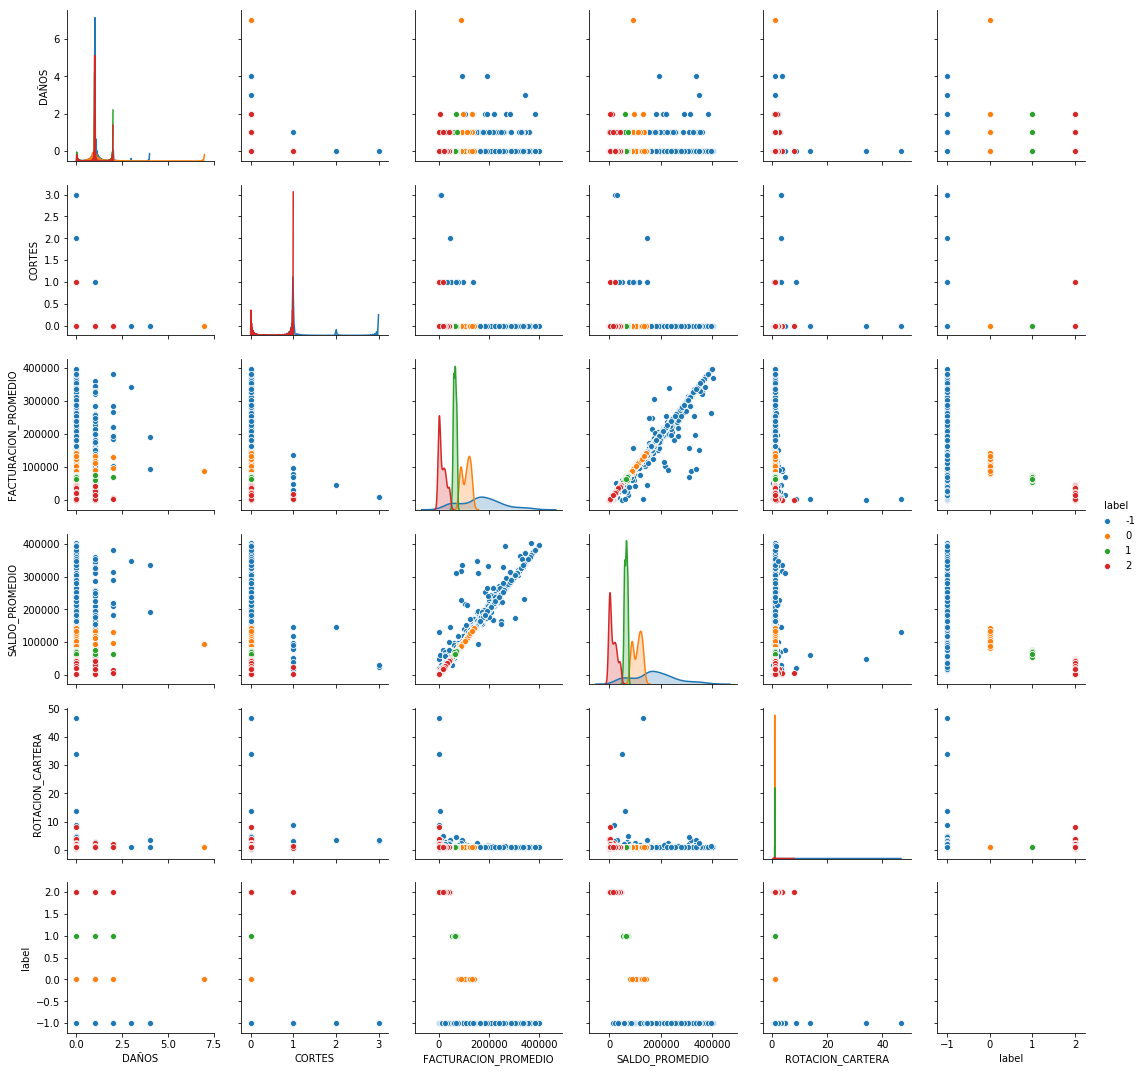

In [314]:
## correlograma
#sample.describe()
sns.pairplot(sample , hue='label')

## Guardando resultados

In [315]:
#Asignacion de clusters  
#col_id['label2']=labels_

In [316]:
#GUARDANDO RESULTADOS
#col_id.to_csv('resultados.csv', sep=';' , index=False , decimal = ',')

In [317]:
sample.shape

(1621, 6)

In [318]:
fig = scatter(3,4)
py.iplot(fig ,   filename='scatter_hdbscan')

In [319]:
sample.columns

Index(['DAÑOS', 'CORTES', 'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO',
       'ROTACION_CARTERA', 'label'],
      dtype='object')

In [320]:
fig = caja(sample['SALDO_PROMEDIO'])
py.iplot(fig ,   filename='caja') 

In [321]:
## COORDENADAS PARALELAS 
data = [
    go.Parcoords(
        line = dict(color = labels_   , colorscale=[ 
                        [0.0               ,'rgb(204,204,204)', ],
                        [0.0111111111111111,'rgb(56,217,113 , 0.2)', ],
                        [0.1111111111111111,'rgb(250,135,117, 0.2)', ],
                        [0.2222222222222222,'rgb(255,215,0, 0.2)', ],
                        [0.2555555555555555,'rgb(87,215,222, 0.2)',  ],
                        [0.3333333333333333,'rgb(205,52,181, 0.2)', ],
                        [0.4444444444444444,'rgb(0,0,255, 0.2)', ],
                        [0.5555555555555556,'rgb(231,58,52, 0.2)', ],
                        [0.6666666666666666,'rgb(157,2,215, 0.2)', ],
                        [0.7777777777777778,'rgb(118,245,60, 0.2)',  ],
                        [0.8888888888888888,'rgb(234,95,148, 0.2)',  ],
                        [1.0               ,'rgb(255,177,78, 0.2)'  ]]  ) ,  
        dimensions = list([
            dict( #range = [0,8], 
                label = sample.columns[0] ,      values = X[:, 0]),
            dict( range = [0,400000],
                label = sample.columns[1],       values = X[:, 1]),
            dict( range = [0,400000],
                label = sample.columns[2],       values = X[:, 2]),
            dict( #range = [0,8],
                label = sample.columns[3],       values = X[:, 3]),
            dict( range = [0.8 ,5 ], 
                label = sample.columns[4],       values = X[:, 4]),
            
         #   dict( #range = [0,500000], 
         #       label = sample.columns[5],       values = X[:, 5]),    
            
            
         #   dict( #range = [0,3],
         #       label = sample.columns[6],       values = X[:, 6]),  
         #   dict( #range = [0,8],
         #       label = sample.columns[7],       values = X[:, 7]), 
         #  dict( #range = [0,8],
         #      label = sample.columns[8],        values = X[:, 8]), 
         #  dict( #range = [0,8],
         #      label = sample.columns[9],        values = X[:, 9]), 
         #  dict( #range = [0,8],
         #      label = sample.columns[10],        values = X[:, 10]),  
            dict( #range = [-1, n_clusters_-1 ],#   K CLUSTERS
                label = 'CLUSTER',                values = labels_) 
        ])
    )
]

layout = go.Layout(
    title='Segmentación de clientes HDBSCAN '+str(registros)+' Registros'+' '+str(n_clusters_)+' Clusters' ,
    plot_bgcolor = '#FFFFFF',
    paper_bgcolor = '#FFFFFF'
) 
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'hdbscan914'+str(registros))

In [312]:
len(sample.columns)

6

In [236]:
np.unique(sample.label)

array([-1,  0,  1], dtype=int64)

Text(0.5,1,'HDBSCAN')

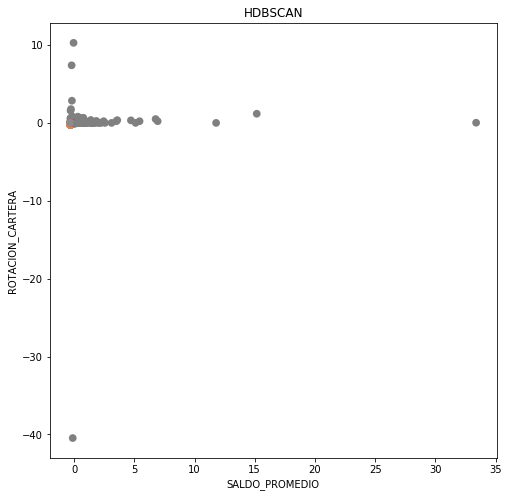

In [51]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.scatter( X.T[5] , X.T[6], s=60, linewidth=0, c=colors, alpha=1)
#plt.ylim(0.9,7)
#plt.xlim(0,1000000)
plt.xlabel('SALDO_PROMEDIO' ) #4
plt.ylabel('ROTACION_CARTERA') 
plt.title('HDBSCAN')

## Anexo 

In [ ]:
## Grid search
#Se ultiliza para optimizar los hiperparametros de un un modelo , vectorizando las entradas
from sklearn.metrics import silhouette_score as sc
from sklearn.model_selection import GridSearchCV
import hdbscan 
X = np.array(sample ) 


## parte 1 
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    
    #hdbscan = hdbscan.HDBSCAN(8).fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    #num_samples = len(X.index)
    num_samples = X.shape[0]
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return sc(X, cluster_labels)
    
def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(X, clusters )
    return score
    
    
cv = [(slice(None), slice(None))] 
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)

import hdbscan   
param_grid = {"min_cluster_size": list(range(2, 117))}
estimator=hdbscan.HDBSCAN().fit(X)
gs = GridSearchCV(estimator,
                  param_grid=param_grid, 
                  scoring=silhouette_score(estimator , X),
                  cv=cv, 
                  n_jobs=-1)

gs.fit(sample)


##### parte 2 
def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(sample, labels_, metric='precomputed')
    return score

ca = KMeans()
param_grid = {"n_clusters": range(2, 11)} 

param_dict ={}


from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)
# run randomized search
search = GridSearchCV(
    ca,
    param_grid=param_grid,
    n_iter=9,
    scoring=silhouette_score(ca, X),
    cv=cv 
    )
search.fit(sample)